## 0 Import all neccesary packages

In [1]:
#Within AS
# Caching Rate
import random
from multiprocessing import Queue
import sys
import sqlite3

import re
import optparse
import logging
import numpy
import logging
from visualize import visualizer as vis


import threading
from user import User

import sched, time
from topology_manager import TopologyManager, Paths, SocialPaths
import tempfile

import matplotlib.pyplot as plt
import networkx as nx

from zipf import gen_biased_zipf_requests, gen_zipf_requests, gen_bilateral_biased_zipf_requests
from Autonomous_System import AS
import warnings
warnings.filterwarnings('ignore')
from statistics import mean
import os

In [2]:
def zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0):
    alpha = 1
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
    return pattern

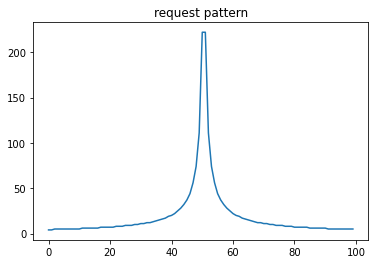

In [3]:
pattern = zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0)
plt.plot(pattern.keys(), pattern.values())
plt.title('request pattern')
plt.show()

## 1 Prepare instruaction parser

In [4]:
parser = optparse.OptionParser()
parser.add_option("-c", "--cache-size-per-node",
              dest="cache_size_per_node",
              help="space of cache allocated for every node in the topology",
              type=int,
              )
parser.add_option("-s", "--strategy",
              dest="caching_strategy",
              help="caching Strategy used for evaluating the trace"
              )
parser.add_option("-u", "--social-connections",
              dest="social_graph",
              help='social connections between users of the trace. Every trace includes users that executes actions.'
)
parser.add_option("-t", "--topology",
              dest="network_topology",
              help='network topology used for executing the trace.'
)
parser.add_option("-f", "--trace-file",
              dest="trace",
              default="",
              help='the trace to be executed',
)
parser.add_option("-p", "--replacement-policy",
              dest="replacement_policy",
              help='replacement policy used at every network node.',
)
parser.add_option("-m", "--mobility-enabled",
              dest="mobility_enabled",
              default=False,
              action="store_true",
              help="Enable mobility of users"
)
parser.add_option("-d", "--debug",
              dest="debug",
              default=False,
              action="store_true",
              help="Enable debugging options"
)
parser.add_option("-r", "--step-printing",
              dest="step_printing",
              default="",
              help = ""
)
parser.add_option("-z", "--zipf",
              dest="zipf",
              default=False,
              action="store_true",
              help = ""
)
parser.add_option("-a", "--zipf_parameter",
              dest="zipf_parameter",
              default=1.0,
              help="set zipf parameters",
              type=float,
)
parser.add_option("-e", "--method",
                 dest = "method",
                 default='random',
                 help = "random/geographical/onepublisher"
)
parser.add_option("-g", "--single-user",
                 dest = "single",
                 default=False,
                 action="store_true",
                 help = "if set, each topology node comes with only one user"
)
parser.add_option("-v", "--verbose",
                 dest = "verbose",
                 default=False,
                 action="store_true",
                 help = "if set, print cache storage info"
)

<Option at 0x1286d05b0: -v/--verbose>

In [5]:
def setup_logger(logger_name, log_file, level=logging.INFO, format_style = '%(asctime)-15s %(message)s',verbose=True):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(format_style)
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)
    l.addHandler(fileHandler)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)
    l.addHandler(streamHandler)
    l.setLevel(level)
    return l

# 🤟🏻 2 define simulation program

In [6]:
class Executor(object):
    def __init__(self, logger, social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename = '', mobility_enabled = False, step_printing = [], topology_file = None, zipf = False, method = 'random', single = False, verbose = False):
        self.lock = threading.Lock()
        self.condition = threading.Condition()
        #########################################
        #Initialize AS
        ##########################################
        nodes = list(topology.nodes())
        try:
            nodes.remove("server")
        except:
            pass
        self.AS = AS(nodes, True)
        logger.info("initialized Autonomous System")
        #########################################
        # Configuration
        #########################################
        self.round = 0
        ## Configure Cache
        self.num_of_request = 2000
        self.initialized_server = False
        self.num_of_content = 1000
        self.contents = ["/content/%s"%str(i) for i in range(self.num_of_content)]
        #########################################
        self.conf = {}
        self.conf['caching_strategy'] = caching_strategy
        self.conf['cache_policy'] = cache_policy
        self.conf['sequence_from_file'] = sequence_filename != ''
        self.conf['step_printing'] = step_printing
        self.method = method
        self.zipf_para = 1
        if self.conf['step_printing'] != None:
            self.steps = 0
        else:
            self.steps = None
        self.verbose = verbose
        #print("singledemo",single)
        #print("zipfdemo",zipf)

        ##########################################3
        # The topology manager handles user connection to CCN nodes.
        self.request_nodes = list(topology)
        self.topology = topology
        self.add_server_node()
        if single:
            self.social_nodes = self.topology
        ##############################################
        # Debugging
        #print(self.topology.nodes())
        logger.debug('Topology manager, connect users started')
        topology_coords = nx.spring_layout(topology)
        #topology_coords = {}
        #for node in topology.nodes():
        #    topology_coords[node] = (
        #            random.randint(0, 100),
        #            random.randint(0, 100)
        #    )
        self.topology_coords = topology_coords
        if single:
            self.social_graph = self.topology
            self.topology_nodes = TopologyManager(self.topology, self.topology, topology_coords, mobility_enabled, topology_file = topology_file)
        else:
            self.topology_nodes = TopologyManager(self.topology, self.social_graph, topology_coords, mobility_enabled, topology_file = topology_file)
        # 社交用户与节点之间关系为随机指定型
        # 后续的请求是用户发出的，所以，主要是要看如何将用户与请求 Pattern之间建立起关系
        self.topology_nodes.set_method(self.method)
        # 从网络中随机初始化网络节点
        # 从Social Network中随机初始化社交节点位置
        if not single:
            for user in social_graph.nodes():
                # update user node(user,pos)
                # initiate user position(coords_user)
                # 将用户映射到最近的拓扑节点上
                self.topology_nodes.update_user_position(user,(random.randint(0, 100), random.randint(0, 100)))
            self.topology_nodes.update_all_users_position()
        else:
            # 在单用户场景中，我们需要将用户初始化于相应的节点中
            for node in topology.nodes():
                    #TODO
                    self.topology_nodes.update_user_node(node,node)
        logger.debug('Topology manager, connect users finished')

        #
        self.users = {}
        for user in self.social_graph.nodes():
            self.users[user] = User(user)

        logger.debug('Start simulation')
        # debugging
        #print(self.topology_nodes.paths._path)

        self.sched = sched.scheduler(time.time, time.sleep)

        # Generate Sequence
        #print "generate sequence"
        if sequence_filename == '':
            self.generate_sequence()
        else:
            self.initialize_scheduler_from_file(sequence_filename)

        # Initialize Caches
        self.lock.acquire()
        # !!Cache Strategy Upper
        caching_strategy_upper = self.conf['caching_strategy'].upper()
        cm = getattr(getattr(__import__('cache_management.%s'%caching_strategy_upper), caching_strategy_upper), caching_strategy_upper)
        self.caches = cm(
                self.conf['cache_policy'],
                cache_size,
                self.social_graph,
                self.topology,
                self.topology_nodes,
                threshold = None
        )
        logger.debug('Loaded caching strategy')
        self.lock.release()
        self.initialize_catalog()
        ##//Initiate
    # Set Zipf parameter
    # default is 1.0
    def set_zipf_parameter(self,alpha):
        self.zipf_para = alpha
    
    def initialize_scheduler(self, offset = 0):
        self.sched = sched.scheduler(time.time, time.sleep)
        ########################
        # TODO 接上Server
        if not self.initialized_server:
            self.initialize_Server()
            self.initialized_server = True
        ##########################
        #self.extract_sequence()
        #########################
        # Pending
        # 插入ZipF请求
        print("Start Simulating!")
        self.gen_zipf_sequence(num_of_content = self.num_of_content, num_of_request = self.num_of_request, r = self.round, offset = offset)
        ######################

        assert not self.sched.empty()


    ##############################################
    #TODO: currently not being used
    def initialize_scheduler_from_file(self, filename):
        self.seq_file = open(filename, 'r')
        self.seq_n = 0
    
    def extract_sequence(self):
        line = self.seq_file.readline()
        while line != '': #Empty line, we reach the end of the sequence
            # Retrieve fields in a line
            # Line format
            # |timestamp | event | User | mobility_x | mobility_y
            result = re.match ("(?P<timestamp>[0-9]*\.[0-9]+)\t(?P<activity>Retrieve|Publish|retrieve|publish|Retrievecontent|Publishcontent)\t(?P<user>[0-9]+)\t\((?P<dependent>.*)\)\t\((?P<mobility_x>[0-9\.]*), ?(?P<mobility_y>[0-9\.]*)\)", line)
            if result != None:
                #print step result
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                    # debugging
                    print(self.steps)
                    self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                    self.steps += 1
                # schedule an event (delay, priority, action, argument=())
                # delay, priority, action, argument=()
                # 使用的工具为：
                # 1 Producer2
                # 2 consumer
                # 3 consume_from_server
                pos = (float(result.group('mobility_x')), float(result.group('mobility_y')))
                if result.group('activity').lower() in ['publishcontent', 'publish']:
                    self.sched.enter(self.seq_n * 0.01, 0, self.producer2, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0] ))
                # 两类consumer
                elif result.group(2).lower() == 'retrieve':
                    self.sched.enter(self.seq_n * 0.01, 0, self.consumer, (int(result.group('user')), pos,))
                elif result.group(2).lower() == 'retrievecontent':
                    #print(self.seq_n * 0.01, 0,self.consume_from_server, (int(result.group('user'))), pos, "/content/%s"%result.group('dependent').split(',')[0])
                    self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
            else:
                print("repr line: %s"%repr(line))
                exit(-1)
            self.seq_n+=1
            line=self.seq_file.readline()
    def initialize_catalog(self):
        self.f = tempfile.NamedTemporaryFile(delete=True, dir='/tmp/')
        self.conn = sqlite3.connect(self.f.name)
        self.c = self.conn.cursor()

        #c.execute('''DROP table catalog''')
        self.c.execute('''CREATE TABLE catalog
                     (content_name text, publisher int, date double, refer text, refered_level int, topic int)''')

    def generate_sequence(self, sequence = []):
        assert type(sequence) == list
        if sequence == []:
            self.sequence = [random.randint(0, len(self.social_graph.nodes())-1) \
                for i in range(0, len(self.social_graph)*40)]
            random.shuffle(self.sequence)
        else:
            self.sequence = sequence

    ###################################
    # 加入Server节点
    def add_server_node(self):
        node = random.choice(list(self.topology.nodes()))
        self.topology.add_node("server")
        self.topology.add_edge(node,"server")
        self.server = "server"
    ############################################
    # Initialize Server
    # 随机选取一个节点
    # 作为Server接上内容
    def initialize_Server(self):
        #################################
        # TODO
        # 找到中心节点
        # 加入一个Server节点
        # Pending
        for content in self.contents:
            self.sched.enter(self.seq_n * 0.01, 0, self.producer3, (self.server, content))
        #################################

    #################################
    # 生成符合Zipf分布的请求，并插入仿真器中
    # TODO:a Zipf sequence generator
    # Pending 01 将请求插入进编辑器中
    #def generate_Zipf_sequence(self,sequence = []):
    def zipf_generator(self,num_of_content, num_of_request, offset):
        alpha = self.zipf_para
        req, _ = gen_bilateral_biased_zipf_requests(alpha = alpha,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
        return req
        
    def gen_zipf_sequence(self, num_of_content = 1000, num_of_request = 10000, r = 0, offset = 0):
        sequence = self.zipf_generator(num_of_content, 10*num_of_content, offset)
        if len(sequence)>=num_of_request:
            requests = sequence[:num_of_request]
        else:
            while(num_of_content):
                requests += sequence[:min(num_of_sequence,len(sequence))]
        #consume_from_server(user,position, contentname)
        # nodes must convert to list, or error appears
        if self.conf['caching_strategy'].upper() == "POP":
            for request in requests:
                ##############################################
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                        self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                        self.steps += 1
                ##############################################
                request_node = random.choice(self.request_nodes)
                while(request_node == "server"):
                    request_node = random.choice(self.request_nodes)
                #consume_from_server(user,position, contentname)
                #目标是先从目标节点进行查找
                ## Scheduler 的用法
                # scheduler.enter(delay, priority, action, argument=(), kwargs={})
                # Pending# consume from server 应该被改成从目标中获取
                #print(self.social_graph.nodes())
                #pos = self.topology_coords[request_node]
                #self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
                req = self.contents[request]
                # print(request_node, type(pos), type(req))
                # print(self.seq_n * 0.01, 0, self.consume_from_server, request_node, pos, req)

                self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_target, (request_node, req))
                self.seq_n+=1
        else:
            for request in requests:
                ##############################################
                #if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                #        self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                #        self.steps += 1
                ##############################################
                request_node = random.choice(self.request_nodes)
                while(request_node == "server"):
                    request_node = random.choice(self.request_nodes)
                #consume_from_server(user,position, contentname)
                pos = self.topology_coords[request_node]
                req = self.contents[request]
                # print(request_node, type(pos), type(req))
                self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server,(request_node, pos, req))

            
                self.seq_n+=1
        print("total seq num: ",self.seq_n)
     #################################
    
    def run(self, offset = 0):
        #print "the process begins"
        self.initialize_scheduler(offset = offset)
        self.sched.run()
        self.round += 1
        time.sleep(2)

        
    def __del__(self):
        self.conn.close()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer3(self, social_publisher, content, reference = '', topic = 0):
        #self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer2(self, social_publisher, position, content, reference = '', topic = 0):
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    ## Producer with position This is already abandoned~
    def producer(self, social_publisher, position, reference = '', topic = 0):
        logger.error("WARNING, this function is deprecated")
        exit(-1)
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
            topic = self.users[social_publisher].decide_next_topic()
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    #consume_from_server(user,position, contentname)
    def consume_from_server(self, social_issuer, position, content_name):
        #print("Here")
        #print "consume_from_server %s"%content_name
        # 首先将用户的位置进行更新为新的地点
        self.topology_nodes.update_user_position(social_issuer, position)
        # 然后
        content_retrieved = {}
        last = 0
        #寻找到存储这个内容的节点
        # Print Flag
        #print("Consume: ",content_name)
        for row in self.c.execute('SELECT * FROM catalog WHERE content_name == \"%s\" LIMIT 1'%( content_name )):
            # row的格式是：
            # content_name text, publisher int, date double, refer text, refered_level int, topic int
            last = row[0]
            reference = row[3]
            referer_level = row[4]
            topic = row[5]
            interest = last
            #从拓扑图中获取路径
            # 由于获取的时候
            # Print Flag
            
            path = self.topology_nodes.get_path(social_issuer, row[1])
            # Retrieve content and calculate statistics
            self.lock.acquire()
            self.caches._retrieve_from_caches(interest, path)
            self.lock.release()
        #if self.verbose:
        #    print(self.printStats())

    def consumer(self, social_issuer, position):
        self.topology_nodes.update_user_position(social_issuer, position)
        content_retrieved = {}
        for social_neighbour in self.social_graph.neighbors(social_issuer):
            topology_neighbour = self.topology_nodes[social_neighbour]
            last = 0
            
            for row in self.c.execute('SELECT * FROM catalog WHERE publisher=%s and date BETWEEN %2f AND %2f ORDER BY date DESC LIMIT 1'%(social_neighbour, time.time()-0.2, time.time())):
                last = row[0]
                reference = row[3]
                referer_level = row[4]
                topic = row[5]
                #detecting original consumer
                while referer_level > 0:
                    for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" ORDER BY date DESC LIMIT 1'%reference):
                        last = row[0]
                        reference = row[3]
                        referer_level = row[4]
                        topic = row[5]
                #print row
                interest = last
                path = self.topology_nodes.get_path(social_issuer, social_neighbour)
                self.lock.acquire()
                self.caches._retrieve_from_caches(interest, path)
                self.lock.release()
            if self.verbose:
                print(self.printStats())
#########################################################
    # TODO: 先从目标节点中尝试获取缓存信息，然后再尝试从Server处获取缓存信息
    # Pending 02
    def consume_from_target(self, consumer, content_name) :
        # 目标节点
        # Pending： 需要向目标节点发出请求
        # target = hash_target(content_name)
        content_retrieved = False
        target = self.AS.get_node(content_name)
        #print("Consume: ",content_name,"Target is: ", target)
        path_to_target = self.topology_nodes.get_path(consumer, target)
        path_to_server = self.topology_nodes.get_path(consumer, self.server)
        target_to_server = self.topology_nodes.get_path(target,self.server)
        self.lock.acquire()
        self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #try:
            #  从目标节点中进行获取内容
            # retrieve_content(self, interest, target, path_to_target, server, path_to_server):
        #    self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #except:
        #    self.caches._retrieve_from_caches(content_name, path_to_server)
        self.lock.release()
        #if self.verbose:
        #    print(self.printStats())
        return 0
#########################################################
    def get_expired_elements(self):
        # get last element of each social user
        #TODO: refactoring URGENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return 0
    def get_diversity(self):
        return self.stats.get_diversity(self.caches)
    def printStats(self):
        return self.caches.stats_summary()
    #############################################
    # print cache detail
    def printCaches(self):
        return self.caches.print_caches()
    ##############################################
    def printStepSummary(self, timestamp):
        print("=> {0} {1}".format(timestamp, self.caches.stats_summary()))
    def finishSimulation(self):
        del self.caches
        del self.topology_nodes 
        del self.sched
        self.c.close()
        self.lock.acquire()
        self.lock.release()
        self.condition.acquire()
        self.condition.notify()
        self.condition.release()

## 3 😋 Clear logger block

In [7]:
logger = logging.getLogger('logger')
while logger.handlers:
    logger.handlers.pop()
cache_info = logging.getLogger('cache_info')
while cache_info.handlers:
    cache_info.handlers.pop()
    cache_info = logging.getLogger('cache_info')

In [8]:
from importlib import reload
logging.shutdown()
reload(logging)

<module 'logging' from '/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/logging/__init__.py'>

## 4 😯Configure and run

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
def simulate(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        if options.caching_strategy.upper() == "POP":
            result.append(executor.caches.stats._internal_hit)
        else:
            result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

### 4.01 😎 Run POP(Zipf = 1, requests = 2000, topo = GEANT, hit_rate VS capability)

In [ ]:
args = '-c 5 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))

In [ ]:
result = []
simulate(options)

In [ ]:
result_10 = result

In [ ]:
args = '-c 3 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_6 = result

In [ ]:
args = '-c 13 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_26 = result

In [ ]:
args = '-c 15 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_30 = result

In [ ]:
args = '-c 18 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_36 = result

In [ ]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_20 = result

In [ ]:
result = {}
result[5] = result_6
result[10] = result_10
result[16] = result_16
result[20] = result_20
result[26] = result_26
result[30] = result_30
result[35] = result_36

In [ ]:
result

In [ ]:
filename = 'result_POP.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

In [ ]:
f = open(filename, 'rb')
re = pickle.load(f)
print(re)
f.close

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(result.keys()),list(float(mean(value)/2000) for value in result.values()))

### 4.02 😎 Run LCD(Zipf = 1, requests = 2000, topo = GEANT, hit_rate VS capability)

In [12]:
args = '-c 3 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 13:52:38,484 - root - INFO - Enable Debugging
2021-05-26 13:52:38,486 - root - DEBUG - Mobility disabled
2021-05-26 13:52:38,486 - root - DEBUG - Step printing activated
2021-05-26 13:52:38,514 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 517 ms, sys: 21.5 ms, total: 538 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 264 , stretch: 0.897 hop_reduction: 0.103 get_diversity: 0.2419 caching_operations: 1831 eviction_operations: 1831 Satisfied by caches: 264 _interest: 2000, get_rch: 0.132
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 542 ms, sys: 21.8 ms, total: 564 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 336 , stretch: 0.863 hop_reduction: 0.137 get_diversity: 0.2029 cach

In [13]:
result_5 = result

In [14]:
args = '-c 5 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 14:11:18,806 - root - INFO - Enable Debugging
2021-05-26 14:11:18,807 - root - DEBUG - Mobility disabled
2021-05-26 14:11:18,807 - root - DEBUG - Step printing activated
2021-05-26 14:11:18,808 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 676 ms, sys: 25.3 ms, total: 701 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 382 , stretch: 0.8486 hop_reduction: 0.1514 get_diversity: 0.2549 caching_operations: 1740 eviction_operations: 1740 Satisfied by caches: 382 _interest: 2000, get_rch: 0.191
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 580 ms, sys: 19.3 ms, total: 600 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 457 , stretch: 0.8084 hop_reduction: 0.1916 get_diversity: 0.2609 

In [15]:
result_10 = result

In [16]:
args = '-c 8 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 14:29:59,198 - root - INFO - Enable Debugging
2021-05-26 14:29:59,199 - root - DEBUG - Mobility disabled
2021-05-26 14:29:59,200 - root - DEBUG - Step printing activated
2021-05-26 14:29:59,200 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 619 ms, sys: 26.9 ms, total: 646 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 521 , stretch: 0.8071 hop_reduction: 0.1929 get_diversity: 0.25 caching_operations: 1671 eviction_operations: 1671 Satisfied by caches: 521 _interest: 2000, get_rch: 0.2605
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 620 ms, sys: 22.7 ms, total: 643 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 588 , stretch: 0.7366 hop_reduction: 0.2634 get_diversity: 0.2295 c

In [17]:
result_15 = result

In [18]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 14:49:04,445 - root - INFO - Enable Debugging
2021-05-26 14:49:04,446 - root - DEBUG - Mobility disabled
2021-05-26 14:49:04,446 - root - DEBUG - Step printing activated
2021-05-26 14:49:04,447 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 609 ms, sys: 20.1 ms, total: 629 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 555 , stretch: 0.8036 hop_reduction: 0.1964 get_diversity: 0.2434 caching_operations: 1669 eviction_operations: 1669 Satisfied by caches: 555 _interest: 2000, get_rch: 0.2775
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 596 ms, sys: 19.9 ms, total: 615 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 611 , stretch: 0.722 hop_reduction: 0.278 get_diversity: 0.2366 c

In [20]:
result_20 = result

In [21]:
args = '-c 13 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 15:09:27,421 - root - INFO - Enable Debugging
2021-05-26 15:09:27,422 - root - DEBUG - Mobility disabled
2021-05-26 15:09:27,422 - root - DEBUG - Step printing activated
2021-05-26 15:09:27,423 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 596 ms, sys: 22.8 ms, total: 619 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 604 , stretch: 0.7836 hop_reduction: 0.2164 get_diversity: 0.2422 caching_operations: 1623 eviction_operations: 1623 Satisfied by caches: 604 _interest: 2000, get_rch: 0.302
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 600 ms, sys: 21.2 ms, total: 621 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 733 , stretch: 0.6738 hop_reduction: 0.3262 get_diversity: 0.2332 

In [22]:
result_25 = result

In [23]:
args = '-c 15 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 15:28:18,618 - root - INFO - Enable Debugging
2021-05-26 15:28:18,618 - root - DEBUG - Mobility disabled
2021-05-26 15:28:18,619 - root - DEBUG - Step printing activated
2021-05-26 15:28:18,620 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 600 ms, sys: 19.8 ms, total: 620 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 627 , stretch: 0.784 hop_reduction: 0.216 get_diversity: 0.2833 caching_operations: 1622 eviction_operations: 1622 Satisfied by caches: 627 _interest: 2000, get_rch: 0.3135
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 159 ms, sys: 2.51 ms, total: 162 ms
Wall time: 2min 9s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 702 , stretch: 0.6963 hop_reduction: 0.3037 get_diversity: 0.254

In [24]:
result_30 = result

In [39]:
args = '-c 18 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 16:03:26,906 - root - INFO - Enable Debugging
2021-05-26 16:03:26,906 - root - INFO - Enable Debugging
2021-05-26 16:03:26,908 - root - DEBUG - Mobility disabled
2021-05-26 16:03:26,908 - root - DEBUG - Mobility disabled
2021-05-26 16:03:26,909 - root - DEBUG - Step printing activated
2021-05-26 16:03:26,909 - root - DEBUG - Step printing activated
2021-05-26 16:03:26,909 - root - DEBUG - Social Graph loaded
2021-05-26 16:03:26,909 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 583 ms, sys: 24.3 ms, total: 607 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 666 , stretch: 0.7618 hop_reduction: 0.2382 get_diversity: 0.2734 caching_operations: 1580 eviction_operations: 1580 Satisfied by caches: 666 _interest: 2000, get_rch: 0.333
#####################################################################
Round#  2
Sta

In [42]:
result_35 = result

In [44]:
result = {}
result[5] = result_5
result[10] = result_10
result[15] = result_15
result[20] = result_20
result[25] = result_25
result[30] = result_30
result[35] = result_35

In [73]:
result = {5: [264, 336, 348, 351, 375, 365, 370, 306, 325, 326],
 10: [382, 457, 431, 462, 441, 484, 439, 437, 458, 453],
 16: [521, 588, 603, 598, 587, 569, 595, 567, 579, 536],
 20: [555, 611, 622, 624, 616, 618, 661, 658, 654, 648],
 26: [604, 733, 706, 702, 673, 704, 702, 727, 684, 734],
 30: [627, 702, 724, 727, 749, 744, 730, 753, 755, 791],
 35: [666, 745, 808, 840, 784, 802, 786, 797, 758, 796]}

In [74]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('cache_size'):
    os.mkdir('cache_size')
os.chdir('cache_size')
filename = 'result_LCD.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

# 5 😯 Configure and run for different zipf parameter

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
def simulate_zipf(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        if options.caching_strategy.upper() == "POP":
            result.append(executor.caches.stats._internal_hit)
        else:
            result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

### 5.01 😎 Run Zipf(LCD, requests = 2000, topo = GEANT, hit_rate VS capability)

In [57]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.2'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

INFO:root:Enable Debugging


2021-05-27 11:12:17,345 - root - INFO - Enable Debugging


DEBUG:root:Mobility disabled


2021-05-27 11:12:17,347 - root - DEBUG - Mobility disabled


DEBUG:root:Step printing activated


2021-05-27 11:12:17,348 - root - DEBUG - Step printing activated


DEBUG:root:Social Graph loaded


2021-05-27 11:12:17,349 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 555 ms, sys: 19.4 ms, total: 575 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 24 , stretch: 0.9997 hop_reduction: 0.0003 get_diversity: 0.9412 caching_operations: 2000 eviction_operations: 2000 Satisfied by caches: 24 _interest: 2000, get_rch: 0.012
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 561 ms, sys: 21.1 ms, total: 582 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 22 , stretch: 0.9984 hop_reduction: 0.0016 get_diversity: 0.8889 caching_operations: 1998 eviction_operations: 1998 Satisfied by caches: 22 _interest: 2000, get_rch: 0.011
#####################################################################
Round# 

In [58]:
result_zipf_2 = result

In [59]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.4'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

INFO:root:Enable Debugging


2021-05-27 11:15:57,680 - root - INFO - Enable Debugging


DEBUG:root:Mobility disabled


2021-05-27 11:15:57,681 - root - DEBUG - Mobility disabled


DEBUG:root:Step printing activated


2021-05-27 11:15:57,682 - root - DEBUG - Step printing activated


DEBUG:root:Social Graph loaded


2021-05-27 11:15:57,683 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 617 ms, sys: 21.9 ms, total: 639 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 30 , stretch: 0.9976 hop_reduction: 0.0024 get_diversity: 0.7632 caching_operations: 1998 eviction_operations: 1998 Satisfied by caches: 30 _interest: 2000, get_rch: 0.015
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 594 ms, sys: 19.5 ms, total: 614 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 55 , stretch: 0.9898 hop_reduction: 0.0102 get_diversity: 0.6625 caching_operations: 1990 eviction_operations: 1990 Satisfied by caches: 55 _interest: 2000, get_rch: 0.0275
#####################################################################
Round#

In [60]:
result_zipf_4 = result

In [61]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.6'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

INFO:root:Enable Debugging


2021-05-27 11:19:38,058 - root - INFO - Enable Debugging


DEBUG:root:Mobility disabled


2021-05-27 11:19:38,060 - root - DEBUG - Mobility disabled


DEBUG:root:Step printing activated


2021-05-27 11:19:38,061 - root - DEBUG - Step printing activated


DEBUG:root:Social Graph loaded


2021-05-27 11:19:38,062 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 638 ms, sys: 19.5 ms, total: 658 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 105 , stretch: 0.9808 hop_reduction: 0.0192 get_diversity: 0.5222 caching_operations: 1978 eviction_operations: 1978 Satisfied by caches: 105 _interest: 2000, get_rch: 0.0525
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 585 ms, sys: 17.3 ms, total: 602 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 138 , stretch: 0.9533 hop_reduction: 0.0467 get_diversity: 0.4014 caching_operations: 1935 eviction_operations: 1935 Satisfied by caches: 138 _interest: 2000, get_rch: 0.069
#####################################################################
Ro

In [62]:
result_zipf_6 = result

In [63]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.8'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

INFO:root:Enable Debugging


2021-05-27 11:23:18,460 - root - INFO - Enable Debugging


DEBUG:root:Mobility disabled


2021-05-27 11:23:18,461 - root - DEBUG - Mobility disabled


DEBUG:root:Step printing activated


2021-05-27 11:23:18,462 - root - DEBUG - Step printing activated


DEBUG:root:Social Graph loaded


2021-05-27 11:23:18,463 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 635 ms, sys: 21.3 ms, total: 656 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 274 , stretch: 0.9119 hop_reduction: 0.0881 get_diversity: 0.3088 caching_operations: 1867 eviction_operations: 1867 Satisfied by caches: 274 _interest: 2000, get_rch: 0.137
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 646 ms, sys: 20.9 ms, total: 667 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 350 , stretch: 0.8526 hop_reduction: 0.1474 get_diversity: 0.266 caching_operations: 1754 eviction_operations: 1754 Satisfied by caches: 350 _interest: 2000, get_rch: 0.175
#####################################################################
Roun

In [64]:
result_zipf_8 = result

In [65]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 1.0'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

INFO:root:Enable Debugging


2021-05-27 11:26:58,812 - root - INFO - Enable Debugging


DEBUG:root:Mobility disabled


2021-05-27 11:26:58,813 - root - DEBUG - Mobility disabled


DEBUG:root:Step printing activated


2021-05-27 11:26:58,814 - root - DEBUG - Step printing activated


DEBUG:root:Social Graph loaded


2021-05-27 11:26:58,814 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 577 ms, sys: 22.2 ms, total: 599 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 547 , stretch: 0.8038 hop_reduction: 0.1962 get_diversity: 0.2381 caching_operations: 1666 eviction_operations: 1666 Satisfied by caches: 547 _interest: 2000, get_rch: 0.2735
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 627 ms, sys: 27 ms, total: 654 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 661 , stretch: 0.7114 hop_reduction: 0.2886 get_diversity: 0.2377 caching_operations: 1513 eviction_operations: 1513 Satisfied by caches: 661 _interest: 2000, get_rch: 0.3305
#####################################################################
Rou

In [66]:
result_zipf_10 = result

In [67]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 1.2'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

INFO:root:Enable Debugging


2021-05-27 11:30:39,204 - root - INFO - Enable Debugging


DEBUG:root:Mobility disabled


2021-05-27 11:30:39,206 - root - DEBUG - Mobility disabled


DEBUG:root:Step printing activated


2021-05-27 11:30:39,207 - root - DEBUG - Step printing activated


DEBUG:root:Social Graph loaded


2021-05-27 11:30:39,207 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 593 ms, sys: 25.8 ms, total: 618 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 870 , stretch: 0.6452 hop_reduction: 0.3548 get_diversity: 0.2263 caching_operations: 1360 eviction_operations: 1360 Satisfied by caches: 870 _interest: 2000, get_rch: 0.435
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 579 ms, sys: 19.6 ms, total: 598 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 944 , stretch: 0.574 hop_reduction: 0.426 get_diversity: 0.2271 caching_operations: 1250 eviction_operations: 1250 Satisfied by caches: 944 _interest: 2000, get_rch: 0.472
#####################################################################
Round

In [68]:
result_zipf_12 = result

In [69]:
result = {}
result[0.2] = result_zipf_2
result[0.4] = result_zipf_4
result[0.6] = result_zipf_6
result[0.8] = result_zipf_8
result[1.0] = result_zipf_10
result[1.2] = result_zipf_12

In [72]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('zipf'):
    os.mkdir('zipf')
os.chdir('zipf')
filename = 'result_LCD.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()
os.chdir('../')
os.chdir('../')

## 6 Hops Analysis

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
def simulate_hops(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        AS_hops,original_hops = executor.caches.stats.get_hops()
        result.append(AS_hops)
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        #if options.caching_strategy.upper() == "POP":
        #    result.append(executor.caches.stats._internal_hit)
        #else:
        #    result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

In [13]:
args = '-c 3 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 18:27:39,654 - root - INFO - Enable Debugging
2021-06-02 18:27:39,655 - root - DEBUG - Mobility disabled
2021-06-02 18:27:39,657 - root - DEBUG - Step printing activated
2021-06-02 18:27:39,689 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 603 ms, sys: 29 ms, total: 632 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 286 , stretch: 0.8905 hop_reduction: 0.1095 get_diversity: 0.2059 caching_operations: 1824 eviction_operations: 1824 Satisfied by caches: 286 _interest: 2000, get_rch: 0.143
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 639 ms, sys: 26.8 ms, total: 666 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 319 , stretch: 0.8687 hop_reduction: 0.1313 get_diversity: 0.2609 ca

In [14]:
result_5 = result

In [15]:
args = '-c 5 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 18:46:29,478 - root - INFO - Enable Debugging
2021-06-02 18:46:29,478 - root - DEBUG - Mobility disabled
2021-06-02 18:46:29,479 - root - DEBUG - Step printing activated
2021-06-02 18:46:29,480 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 266 ms, sys: 6.41 ms, total: 272 ms
Wall time: 16min 19s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 388 , stretch: 0.8479 hop_reduction: 0.1521 get_diversity: 0.2336 caching_operations: 1741 eviction_operations: 1741 Satisfied by caches: 388 _interest: 2000, get_rch: 0.194
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 240 ms, sys: 5.95 ms, total: 246 ms
Wall time: 15min 41s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 470 , stretch: 0.8006 hop_reduction: 0.1994 get_diversit

In [16]:
result_10 = result

In [17]:
args = '-c 8 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 21:03:38,118 - root - INFO - Enable Debugging
2021-06-02 21:03:38,119 - root - DEBUG - Mobility disabled
2021-06-02 21:03:38,119 - root - DEBUG - Step printing activated
2021-06-02 21:03:38,119 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 412 ms, sys: 12.9 ms, total: 425 ms
Wall time: 15min 41s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 481 , stretch: 0.8275 hop_reduction: 0.1725 get_diversity: 0.2372 caching_operations: 1716 eviction_operations: 1716 Satisfied by caches: 481 _interest: 2000, get_rch: 0.2405
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 247 ms, sys: 6.17 ms, total: 253 ms
Wall time: 17min 48s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 590 , stretch: 0.7431 hop_reduction: 0.2569 get_diversi

In [18]:
result_15 = result

In [19]:
args = '-c 10 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 02:09:55,610 - root - INFO - Enable Debugging
2021-06-03 02:09:55,611 - root - DEBUG - Mobility disabled
2021-06-03 02:09:55,612 - root - DEBUG - Step printing activated
2021-06-03 02:09:55,613 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 230 ms, sys: 5.18 ms, total: 235 ms
Wall time: 34min 4s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 509 , stretch: 0.8193 hop_reduction: 0.1807 get_diversity: 0.284 caching_operations: 1677 eviction_operations: 1677 Satisfied by caches: 509 _interest: 2000, get_rch: 0.2545
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 233 ms, sys: 6.34 ms, total: 239 ms
Wall time: 56min 59s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 620 , stretch: 0.7397 hop_reduction: 0.2603 get_diversity

In [20]:
result_20 = result

In [21]:
args = '-c 13 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 07:00:31,904 - root - INFO - Enable Debugging
2021-06-03 07:00:31,905 - root - DEBUG - Mobility disabled
2021-06-03 07:00:31,905 - root - DEBUG - Step printing activated
2021-06-03 07:00:31,906 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 522 ms, sys: 16.8 ms, total: 539 ms
Wall time: 2min 54s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 534 , stretch: 0.8136 hop_reduction: 0.1864 get_diversity: 0.2463 caching_operations: 1673 eviction_operations: 1673 Satisfied by caches: 534 _interest: 2000, get_rch: 0.267
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 265 ms, sys: 6.25 ms, total: 271 ms
Wall time: 26min 30s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 685 , stretch: 0.6997 hop_reduction: 0.3003 get_diversity

In [22]:
result_25 = result

In [23]:
args = '-c 15 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 08:08:57,020 - root - INFO - Enable Debugging
2021-06-03 08:08:57,021 - root - DEBUG - Mobility disabled
2021-06-03 08:08:57,021 - root - DEBUG - Step printing activated
2021-06-03 08:08:57,022 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 664 ms, sys: 25 ms, total: 689 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 636 , stretch: 0.7809 hop_reduction: 0.2191 get_diversity: 0.2552 caching_operations: 1605 eviction_operations: 1605 Satisfied by caches: 636 _interest: 2000, get_rch: 0.318
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 682 ms, sys: 30.2 ms, total: 712 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 732 , stretch: 0.6802 hop_reduction: 0.3198 get_diversity: 0.2406 ca

In [24]:
result_30 = result

In [25]:
args = '-c 18 -s lcd -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 08:13:21,709 - root - INFO - Enable Debugging
2021-06-03 08:13:21,710 - root - DEBUG - Mobility disabled
2021-06-03 08:13:21,711 - root - DEBUG - Step printing activated
2021-06-03 08:13:21,711 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 649 ms, sys: 28 ms, total: 677 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 644 , stretch: 0.7801 hop_reduction: 0.2199 get_diversity: 0.2548 caching_operations: 1608 eviction_operations: 1608 Satisfied by caches: 644 _interest: 2000, get_rch: 0.322
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 680 ms, sys: 32.9 ms, total: 713 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 775 , stretch: 0.6691 hop_reduction: 0.3309 get_diversity: 0.2225 ca

In [26]:
result_35 = result

In [27]:
result = {}
result[5] = result_5
result[10] = result_10
result[15] = result_15
result[20] = result_20
result[25] = result_25
result[30] = result_30
result[35] = result_35

In [28]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('hops'):
    os.mkdir('hops')
os.chdir('hops')
filename = 'result_LCD.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()
os.chdir('../')
os.chdir('../')

## 🥸 Test and demo

In [ ]:
offset = [0,2,4,6,8,10,12,14,16,18,20]
contents = ["/content/%s"%str(i) for i in range(1000)]
patterns = {}
for i in range(len(offset)):
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = 1000, number_of_request = 10000, offset = offset[i])
    patterns[i] = pattern
    #plt.plot(pattern.keys(), pattern.values())
    
data = []

for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][502])
plt.plot(data)


## 5 Visualization

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result)

In [ ]:
#TOPOLOGY_GRAPH = options.network_topology
#G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
G = executor.topology
topo_vis = vis(G, executor.topology_coords)
node = random.choice(list(G.nodes()))
G.add_node("server", label = "server")
G.add_edge(node,"server")

In [ ]:
AS1 = AS(list(G.nodes()),True)
print(AS1.get_nodes())
AS1.get_node("coconut")

In [ ]:
        pos = executor.topology_coords
        Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
        fig = plt.figure(figsize=(10, 10))
        ax0 = fig.subplots()
        nx.draw_networkx_nodes(G, pos,  node_size = 80)
        nx.draw_networkx_edges(G,pos, alpha = 0.6)
        pos1 = {}
        for p in pos:  # raise text positions
            #pos[p] = [p[0]+0.05, p[1]+0.04]
            pos1[p] = pos[p][0]+0.005,pos[p][1]+0.003
        plt.title('label graph')
        nx.draw_networkx_labels(G, pos1,  font_size = 20)
        plt.show()
        #print(pos, pos1)

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.label_graph(font_size = 1, node_size = 210)

# 节点的介度

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
print(sum(d.values()))

In [ ]:
print(44/21)

In [ ]:
SOCIAL_GRAPH = options.social_graph
G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
social_vis = vis(G)

In [ ]:
social_vis.degree_graph()

In [ ]:
social_vis.simple_graph(node_size = 10, alpha = 0.2, size = 12)

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.directed_graph()

In [ ]:
topo_vis.degree_graph()

In [ ]:
topo_vis.simple_graph()

In [ ]:
args = '-c 2 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True'
(options,args) = parser.parse_args(args.split(' '))

In [ ]:
TOPOLOGY_GRAPH = options.network_topology
G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
topo_vis = vis(G)

In [ ]:
topo_vis.degree_graph()

In [ ]:
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_nodes_from("Hello")
K3 = nx.Graph([(0, 1), (1, 2), (2, 0)])
G.add_nodes_from(K3)

In [ ]:
viser = vis(G)
viser.directed_graph()

In [ ]:
viser.degree_graph()